In [1]:
pip install SimpleITK

     |████████████████████████████████| 47.4MB 113kB/s 


In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

import sys
sys.path.insert(0,'/content/drive/MyDrive/FYP/Model/')

from LungSegmentation_Threshold_3D import get_segmented_lungs

In [3]:
X_train = np.load('/content/drive/MyDrive/FYP/2D_Class/X_train_2D_Class.npy')
y_train = np.load('/content/drive/MyDrive/FYP/2D_Class/y_train_2D_Class.npy')
X_test = np.load('/content/drive/MyDrive/FYP/2D_Class/X_test_2D_Class.npy')
y_test = np.load('/content/drive/MyDrive/FYP/2D_Class/y_test_2D_Class.npy')

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((596, 128, 128, 3), (596,), (150, 128, 128, 3), (150,))

In [ ]:
# from keras.utils import to_categorical
# y_train = to_categorical(y_train)
# y_test = to_categorical(y_test)

# X_train.shape, y_train.shape, X_test.shape, y_test.shape

((596, 128, 128, 3), (596, 2), (150, 128, 128, 3), (150, 2))

In [4]:
import cv2

In [ ]:
scan = X_train[0].copy()
scan_1 = cv2.cvtColor(scan,cv2.COLOR_BGR2GRAY)
scan_1.shape

(128, 128)

In [ ]:
lungMask = np.array(get_segmented_lungs(scan_1,threshold=150))
scan_1[~lungMask] = 0

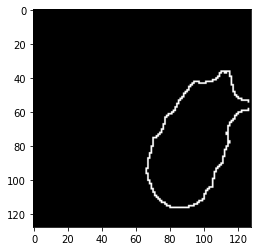

In [ ]:
plt.imshow(lungMask ,cmap='gray')

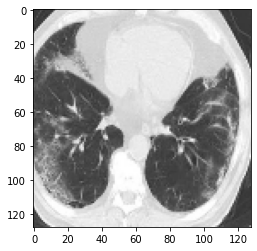

In [ ]:
plt.imshow(scan,cmap='gray')

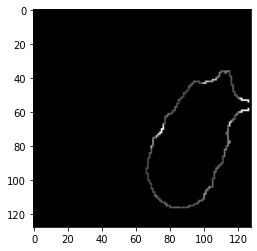

In [ ]:
plt.imshow(scan_1,cmap='gray')

In [5]:
from keras.models import *
from keras.layers.merge import concatenate
from keras.layers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.optimizers import Adam

In [6]:
INPUT_SHAPE = (128, 128, 3)   #(64, 64, 3)
inp = keras.layers.Input(shape=INPUT_SHAPE)

conv1 = keras.layers.Conv2D(64, kernel_size=(3, 3), 
                               activation='relu', padding='same')(inp) #32 filters , 
pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
norm1 = keras.layers.BatchNormalization()(pool1)
drop1 = keras.layers.Dropout(0.5)(norm1)

conv2 = keras.layers.Conv2D(128, kernel_size=(3, 3), 
                               activation='relu', padding='same')(drop1)
pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
norm2 = keras.layers.BatchNormalization()(pool2)
drop2 = keras.layers.Dropout(0.5)(norm2)

conv3 = keras.layers.Conv2D(256, kernel_size=(3, 3), 
                               activation='relu', padding='same')(drop2)
pool3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)
norm3 = keras.layers.BatchNormalization()(pool3)
drop3 = keras.layers.Dropout(0.5)(norm3)

flat = keras.layers.Flatten()(drop3)  #Flatten the matrix to get it ready for dense.

hidden1 = keras.layers.Dense(512, activation='relu')(flat)
norm3 = keras.layers.BatchNormalization(axis = -1)(hidden1)
drop3 = keras.layers.Dropout(rate=0.2)(norm3)
hidden2 = keras.layers.Dense(256, activation='relu')(drop3)
norm4 = keras.layers.BatchNormalization(axis = -1)(hidden2)
drop4 = keras.layers.Dropout(0.5)(norm4)

out = keras.layers.Dense(1, activation='sigmoid')(drop4)   #units=1 gives error


model = keras.Model(inputs=inp, outputs=out)

initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

checkpointer_ = keras.callbacks.ModelCheckpoint("2D_CT_BinaryClassification.h5", monitor='val_loss',save_best_only=True)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
                loss='binary_crossentropy',
                metrics=['accuracy'])

In [7]:
with tf.device('/device:GPU:0'):

  hist_1 = model.fit(
            X_train,
            y_train,
            batch_size=50,
            epochs=50,
            shuffle=False,
            verbose=2,
            #validation_data=(X_test,y_test),
            validation_split = 0.2,
            callbacks=[checkpointer_]

  )

Epoch 1/50
10/10 - 19s - loss: 0.9455 - accuracy: 0.5861 - val_loss: 9.2038 - val_accuracy: 0.4917
Epoch 2/50
10/10 - 0s - loss: 0.5605 - accuracy: 0.7332 - val_loss: 4.7459 - val_accuracy: 0.5000
Epoch 3/50
10/10 - 0s - loss: 0.5410 - accuracy: 0.7500 - val_loss: 4.3823 - val_accuracy: 0.5000
Epoch 4/50
10/10 - 0s - loss: 0.4068 - accuracy: 0.8088 - val_loss: 3.6994 - val_accuracy: 0.5083
Epoch 5/50
10/10 - 0s - loss: 0.3968 - accuracy: 0.8046 - val_loss: 3.2373 - val_accuracy: 0.5167
Epoch 6/50
10/10 - 0s - loss: 0.3523 - accuracy: 0.8445 - val_loss: 2.8537 - val_accuracy: 0.5333
Epoch 7/50
10/10 - 0s - loss: 0.2729 - accuracy: 0.8845 - val_loss: 2.2702 - val_accuracy: 0.5583
Epoch 8/50
10/10 - 0s - loss: 0.2517 - accuracy: 0.8866 - val_loss: 1.8699 - val_accuracy: 0.5750
Epoch 9/50
10/10 - 0s - loss: 0.2529 - accuracy: 0.8929 - val_loss: 1.4481 - val_accuracy: 0.5917
Epoch 10/50
10/10 - 0s - loss: 0.2305 - accuracy: 0.9097 - val_loss: 1.2023 - val_accuracy: 0.6167
Epoch 11/50
10/10 

In [ ]:
model.load_weights('/content/2D_CT_BinaryClassification.h5')

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test,verbose=2)

5/5 - 0s - loss: 0.5263 - accuracy: 0.7800


In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [ ]:
y_test = [[1,2,3],[4,5,6],[7,8,9]]

70 16 17 47
              precision    recall  f1-score   support

           0       0.80      0.81      0.81        86
           1       0.75      0.73      0.74        64

    accuracy                           0.78       150
   macro avg       0.78      0.77      0.77       150
weighted avg       0.78      0.78      0.78       150



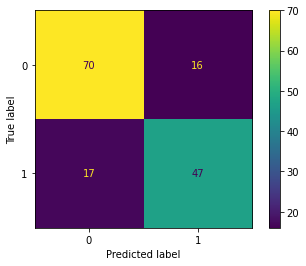

In [ ]:
predict = model.predict(X_test,batch_size=5)
pred = np.where(predict > 0.5,1,0)
pred = np.squeeze(pred)
tn, fp, fn, tp= confusion_matrix(y_test,pred).ravel()
print(tn, fp, fn, tp)
print(classification_report(y_test,np.squeeze(pred)))
ConfusionMatrixDisplay(confusion_matrix(y_test,pred),display_labels=[0,1]).plot()

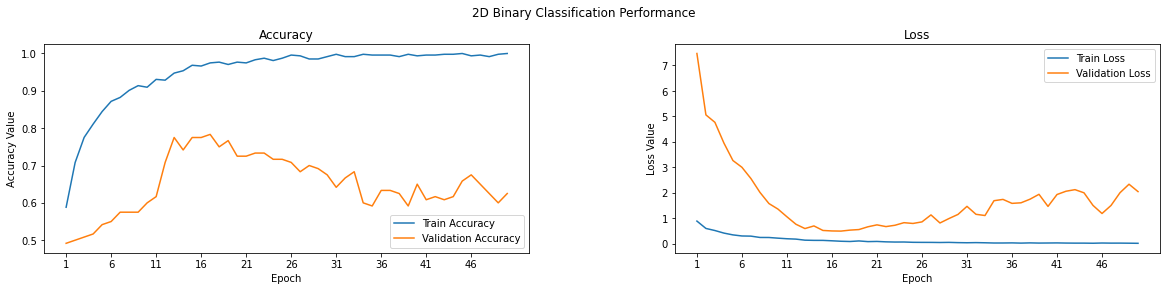

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
t = f.suptitle('2D Binary Classification Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(hist_1.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))

ax1.plot(epoch_list, hist_1.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, hist_1.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, hist_1.history['loss'], label='Train Loss')
ax2.plot(epoch_list, hist_1.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

## LungSeg Binary Class

In [ ]:
import cv2

In [ ]:
X_train_1 =[]
X_test_1 = []

In [ ]:
for x in X_train:

  scan = x.copy()
  scan_1 = cv2.cvtColor(scan,cv2.COLOR_BGR2GRAY)
  lungMask = np.array(get_segmented_lungs(scan_1,threshold=150))
  scan_1[~lungMask] = 0
  X_train_1.append(scan_1)

In [ ]:
for x in X_test:

  scan = x.copy()
  scan_1 = cv2.cvtColor(scan,cv2.COLOR_BGR2GRAY)
  lungMask = np.array(get_segmented_lungs(scan_1,threshold=150))
  scan_1[~lungMask] = 0
  X_test_1.append(scan_1)

In [ ]:
len(X_train_1),len(X_test_1)

(596, 150)

In [ ]:
y_train[0]

1

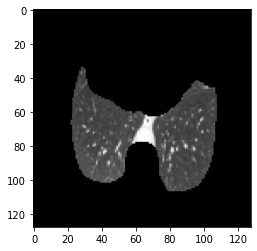

In [ ]:
plt.imshow(X_train_1[25],cmap='gray')

In [ ]:
X_train_1 = np.stack((np.array(X_train_1),)*3, axis=-1)

In [ ]:
X_test_1 = np.stack((np.array(X_test_1),)*3, axis=-1)

In [ ]:
X_train_1.shape

(596, 128, 128, 3)

In [ ]:
model_1 = keras.Model(inputs=inp, outputs=out)


initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

checkpointer_ = keras.callbacks.ModelCheckpoint("2D_CT_LungSegBinaryClassification.h5", monitor='val_loss',save_best_only=True)
model_1.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
                loss='binary_crossentropy',
                metrics=['accuracy'])

In [ ]:
with tf.device('/device:GPU:0'):

  hist_2 = model_1.fit(
            X_train_1,
            y_train,
            batch_size=32,
            epochs=100,
            shuffle=False,
            verbose=2,
            #validation_data=(X_test,y_test),
            validation_split = 0.2,
            callbacks=[checkpointer_]

  )

Epoch 1/100
15/15 - 2s - loss: 1.1250 - accuracy: 0.4853 - val_loss: 1.1918 - val_accuracy: 0.4417
Epoch 2/100
15/15 - 0s - loss: 0.8186 - accuracy: 0.5840 - val_loss: 1.0620 - val_accuracy: 0.5417
Epoch 3/100
15/15 - 0s - loss: 0.6689 - accuracy: 0.6534 - val_loss: 0.9358 - val_accuracy: 0.6083
Epoch 4/100
15/15 - 0s - loss: 0.6022 - accuracy: 0.6954 - val_loss: 0.8332 - val_accuracy: 0.5833
Epoch 5/100
15/15 - 0s - loss: 0.5946 - accuracy: 0.7059 - val_loss: 0.7215 - val_accuracy: 0.6333
Epoch 6/100
15/15 - 0s - loss: 0.5554 - accuracy: 0.7353 - val_loss: 0.7737 - val_accuracy: 0.5917
Epoch 7/100
15/15 - 0s - loss: 0.5170 - accuracy: 0.7500 - val_loss: 0.7803 - val_accuracy: 0.6000
Epoch 8/100
15/15 - 0s - loss: 0.5039 - accuracy: 0.7521 - val_loss: 0.7367 - val_accuracy: 0.5917
Epoch 9/100
15/15 - 0s - loss: 0.4494 - accuracy: 0.8046 - val_loss: 0.7431 - val_accuracy: 0.5917
Epoch 10/100
15/15 - 0s - loss: 0.3961 - accuracy: 0.7920 - val_loss: 0.7340 - val_accuracy: 0.5833
Epoch 11/

In [ ]:
model_1.load_weights('/content/2D_CT_LungSegBinaryClassification.h5')

In [ ]:
loss, accuracy = model_1.evaluate(X_test_1, y_test,batch_size=10,verbose=2)

15/15 - 0s - loss: 0.7079 - accuracy: 0.6133


15 71 6 58
              precision    recall  f1-score   support

           0       0.71      0.17      0.28        86
           1       0.45      0.91      0.60        64

    accuracy                           0.49       150
   macro avg       0.58      0.54      0.44       150
weighted avg       0.60      0.49      0.42       150



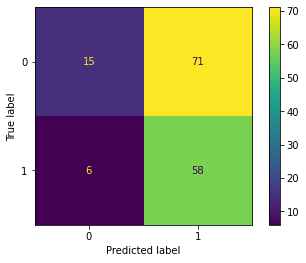

In [ ]:
predict = model_1.predict(X_test,batch_size=32)
pred = np.where(predict > 0.5,1,0)
pred = np.squeeze(pred)
tn, fp, fn, tp= confusion_matrix(y_test,pred).ravel()
print(tn, fp, fn, tp)
print(classification_report(y_test,np.squeeze(pred)))
ConfusionMatrixDisplay(confusion_matrix(y_test,pred),display_labels=[0,1]).plot()

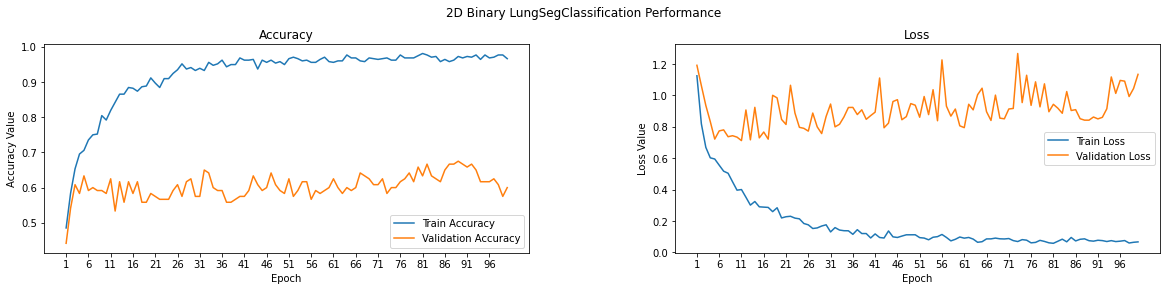

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
t = f.suptitle('2D Binary LungSegClassification Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(hist_2.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))

ax1.plot(epoch_list, hist_2.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, hist_2.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, hist_2.history['loss'], label='Train Loss')
ax2.plot(epoch_list, hist_2.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")